In [1]:
import cv2
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from datetime import datetime
from matplotlib import pyplot as plt

In [ ]:
EPOCHS = 10
IMG_WIDTH = 256
IMG_HEIGHT = 196
NUM_CATEGORIES = 5
# TEST_SIZE = 0.4
GESTURE = {0:"ok", 1:"up", 2:"down", 3:"palm", 4:"l"}

In [ ]:
def load_data(images, labels):
    """
    Load image data from directory `data_dir`.
    Assume `data_dir` has one directory named after each category, numbered
    0 through NUM_CATEGORIES - 1. Inside each category directory will be some
    number of image files.
    Return tuple `(images, labels)`. `images` should be a list of all
    of the images in the data directory, where each image is formatted as a
    numpy ndarray with dimensions IMG_WIDTH x IMG_HEIGHT x 3. `labels` should
    be a list of integer labels, representing the categories for each of the
    corresponding `images`.
    """
    # images = []
    # labels = []
    
    # for dir in range(0, NUM_CATEGORIES):
    #     # get path for each gesture like "/home/arpine/Desktop/data/0":  
    #     d = os.path.join(data_dir, f"{str(dir)}")
    #     # os.listdir(d) return the list of all names of images in that folder
    #     for image_path in os.listdir(d):
    #         # get the full path of specific image 
    #         full_path = os.path.join(data_dir, f"{str(dir)}", image_path)
    #         # Returns an image that is loaded from the specified file
    #         image = cv2.imread(full_path, )
    #     #     print(image.shape)
    #     #     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #     #     print(image.shape)
    #         # cv2.imshow("im", image)
    #         # get dimension for each image
    #         dim = (IMG_WIDTH, IMG_HEIGHT)
    #         # resized the image
    #         image_resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    #     #     print(image_resized.shape)
            
    #     #     add image and their directory name to images and labels list
    #         images.append(image_resized)
    #         labels.append(dir)
    images = np.load(images)
    labels = np.load(labels)

    
    return images, labels

In [5]:
start_time = datetime.now()  
print("Loading ===========") 
# images_test, labels_test = load_data("/home/arpine/Desktop/Gesture/test") 
# images_train, labels_train = load_data("/home/arpine/Desktop/Gesture/train") 
# valid_image, valid_label  = load_data("/home/arpine/Desktop/Gesture/valid")

images_test, labels_test = load_data("images_test.npy", "labels_test.npy") 
images_train, labels_train = load_data("images_train.npy", "labels_train.npy" ) 
valid_image, valid_label  = load_data("images_valid.npy", "labels_valid.npy" )
finish_loading_time = datetime.now()
print("Images load time: ", finish_loading_time - start_time)

Loading ===========
Images load time:  0:00:00.243807


In [12]:
def get_model():
    """
    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a convolutional neural network
    model = tf.keras.models.Sequential(
        [
        # Convolutional layer. Learn 32 filters using a 3x3 kernel
        tf.keras.layers.Conv2D(
            32, (5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        ),
        # Max-pooling layer, using 2x2 pool size
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
       
       
        tf.keras.layers.Conv2D(
            64, (3, 3), activation='relu'
        ),
        # Max-pooling layer, using 2x2 pool size
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        
        tf.keras.layers.Conv2D(
            128, (3, 3), activation='relu' 
        ),
        # Max-pooling layer, using 2x2 pool size
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        
        tf.keras.layers.Conv2D(
            256, (3, 3), activation='relu' 
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        
        tf.keras.layers.Conv2D(
            512, (3, 3), activation='relu' 
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        
        tf.keras.layers.Conv2D(
            1064, (3, 3), activation='relu'
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        
        
        tf.keras.layers.Flatten(),
        # Add a hidden layer with dropout
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        
        # Add an output layer with output units for all 6 gestures
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])
    
       

  
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer ,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

      # Train neural network
    # model.compile(
    #     optimizer='adam',
    #     loss="categorical_crossentropy",
    #     metrics=["accuracy"]
    # )
    # return model

In [6]:
# def get_model():
#     print("====================")
#     model = Sequential()
#     model.add(Conv2D(32, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
#     model.add(BatchNormalization(epsilon=0.0001))
#     model.add(Activation('relu'))
#     model.add(MaxPool2D(pool_size=(2, 2)))

#     model.add(Conv2D(64, (3, 3)))
#     model.add(BatchNormalization(epsilon=0.0001))
#     model.add(Activation('relu'))
#     model.add(MaxPool2D(pool_size=(2, 2)))

#     model.add(Conv2D(128, (3, 3)))
#     model.add(BatchNormalization(epsilon=0.0001))
#     model.add(Activation('relu'))
#     model.add(MaxPool2D(pool_size=(2, 2)))

#     model.add(Conv2D(256, (3, 3)))
#     model.add(BatchNormalization(epsilon=0.0001))
#     model.add(Activation('relu'))
#     model.add(MaxPool2D(pool_size=(2, 2)))

#     model.add(Conv2D(512, (3, 3)))
#     model.add(BatchNormalization(epsilon=0.0001))
#     model.add(Activation('relu'))
#     model.add(MaxPool2D(pool_size=(2, 2)))

#     model.add(Conv2D(1064, (3, 3)))
#     model.add(BatchNormalization(epsilon=0.0001))
#     model.add(Activation('relu'))
#     model.add(MaxPool2D(pool_size=(2, 2)))

#     model.add(Flatten())
#     model.add(Dense(1064))
#     # model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))

#     model.add(Dense(512))
#     # model.add(BatchNormalization())
#     model.add(Activation('relu'))

#     model.add(Dense(NUM_CATEGORIES))
#     model.add(Activation('softmax'))

#     optimizer = Adam(learning_rate=0.0001)
#     model.compile(
#         optimizer=optimizer ,
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )
#     return model




In [9]:
# from sklearn.feature_selection import RFE, SelectKBest, f_classif
# from sklearn.svm import LinearSVC
# from sklearn.ensemble import RandomForestClassifier

print("====================")
y_test = to_categorical(labels_test)
y_train = to_categorical(labels_train)
y_valid = to_categorical(valid_label)

x_train = np.array(images_train)/255
# x_train = x_train.astype('float32')/255

x_test = np.array(images_test)/255
# x_test = x_test.astype('float64')/255
# # print(x_test)
x_valid = np.array(valid_image)/255
# x_valid = x_valid.astype('float64')/255
# X_train = np.array(images_train)
print(x_train.shape)
# X_test = np.array(images_test)
print(x_test.shape)
# X_valid = np.array(valid_image)
print(x_valid.shape)

# Cenetering the data
# X_train_mean = np.mean(X_train, axis = 0)
# X_train_cent = X_train - X_train_mean
# # Normalization
# X_train_std = np.std(X_train, axis = 0)
# X_train_norm = X_train_cent / X_train_std

# # Normalization test set
# X_test_norm = (X_test - X_train_mean) / X_train_std

# # Normalization valid set
# X_valid_norm = (X_valid - X_train_mean) / X_train_std

# clf = LinearSVC(C=0.01, penalty='l1', dual = False)
# clf.fit(x_train, y_train)

# rfe_selector = RFE(clf, 10)
# rfe_selector = rfe_selector.fit(x_train, y_train)

# rfe_values = rfe_selector.get_support()
# selector = SelectKBest(f_classif, k=10)
# select_features = selector.fit_transform(x_train, y_train)




(2980, 196, 256, 3)
(500, 196, 256, 3)
(1010, 196, 256, 3)


In [13]:
print("====================")
# Get a compiled neural network
fitting_time = datetime.now()
model = get_model()

# Fit model on training data
history = model.fit(x_train, y_train, epochs=EPOCHS,  validation_data = (x_valid, y_valid))
# model.fit(train_data, epochs= EPOCHS)
# Evaluate neural network performance
model.evaluate(x_test, y_test, verbose=2)
finish_loading_time = datetime.now()

print("NN fit time: ", datetime.now() - fitting_time)


Epoch 1/10
94/94 [==============================] - 12s 115ms/step - loss: 1.6106 - accuracy: 0.1983 - val_loss: 1.6093 - val_accuracy: 0.2000
Epoch 2/10
94/94 [==============================] - 10s 107ms/step - loss: 1.6093 - accuracy: 0.2107 - val_loss: 1.6084 - val_accuracy: 0.2000
Epoch 3/10
94/94 [==============================] - 10s 108ms/step - loss: 1.5763 - accuracy: 0.2718 - val_loss: 1.5544 - val_accuracy: 0.2941
Epoch 4/10
94/94 [==============================] - 10s 107ms/step - loss: 1.2586 - accuracy: 0.4587 - val_loss: 1.4508 - val_accuracy: 0.4000
Epoch 5/10
94/94 [==============================] - 10s 107ms/step - loss: 0.8674 - accuracy: 0.6406 - val_loss: 1.5178 - val_accuracy: 0.4337
Epoch 6/10
94/94 [==============================] - 10s 107ms/step - loss: 0.5994 - accuracy: 0.7574 - val_loss: 1.6566 - val_accuracy: 0.4267
Epoch 7/10
94/94 [==============================] - 10s 109ms/step - loss: 0.4728 - accuracy: 0.8114 - val_loss: 2.0972 - val_accuracy: 0.4168

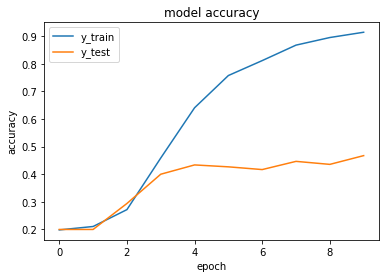

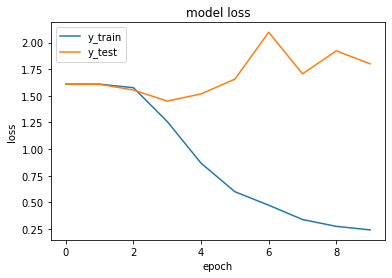

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['y_train', 'y_test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['y_train', 'y_test'], loc='upper left')
plt.show()

In [ ]:
model.summary()

In [ ]:
video = cv2.VideoCapture(0)
    
while True:
        # Capture the video frame
        ret, img = video.read()

         # Display the resulting frame
        # to flip the video with 180 degree 
        image = cv2.flip(img, 1)
        #cv2.imshow('frame', image)
        
        # save image for prediction
        image = cv2.imwrite('Frame'+str(0)+'.jpg', image)
        image_addr = "Frame0.jpg"
        # image = cv2.imread(image_addr)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # cv2.imshow("gray", image)
        # handsModule = mediapipe.solutions.hands
        # with handsModule.Hands(static_image_mode=True) as hands:

        #         image = cv2.imread(image_addr)
        #         results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        #         image_height, image_width, _ = image.shape

        #         if results.multi_hand_landmarks:
        #                 for hand_landmark in results.multi_hand_landmarks:
        #                         x = [landmark.x for landmark in hand_landmark.landmark]
        #                         y = [landmark.y for landmark in hand_landmark.landmark]

        #                         center = np.array([np.mean(x)*image_width, np.mean(y)*image_height]).astype('int32')
        #                 #     cv2.imshow('video', image)
        #                         cv2.circle(image, tuple(center), 10, (255,0,0), 1) #for checking the center
        #                         cv2.rectangle(image, (center[0]-128,center[1]-128), (center[0]+128,center[1]+128), (255,0,0), 1)
        #                         hand = image[center[1]-128:center[1]+128, center[0]-128:center[0]+128]
        #                         # hand = cv2.resize(hand, dim, interpolation = cv2.INTER_AREA)
        #                 #     cv2.imshow('video', hand)
        #                         if hand.shape==(256, 256, 3):

        #                                 image_hand = cv2.imwrite(image_addr, hand)

        # rest, thresh = cv2.threshold(image, 70, 255, cv2.THRESH_BINARY)
        # _, contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # image = cv2.imwrite(address, thresh)
        # image = cv2.imwrite('Frame'+str(0)+'.png', image)

        # image = "Frame0.png"
        # image = cv2.cvtColor(image_addr, cv2.COLOR_BGR2GRAY)
        dim = (IMG_WIDTH, IMG_HEIGHT)
        
        # image = tf.keras.preprocessing.image.load_img(image_addr, color_mode="grayscale", target_size=dim)
        image = tf.keras.preprocessing.image.load_img(image_addr, target_size=dim)

        # Converts a PIL Image instance to a Numpy array. Return a 3D Numpy array.
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        # Convert single image to a batch.
        input_arr = np.array([input_arr])
        input_arr = input_arr.astype('float32')/255
        # input_arr = input_arr.astype('float32')



        # predict_min = input_arr.min(axis=(1, 2), keepdims=True)
        # predict_max = input_arr.max(axis=(1, 2), keepdims=True)

        # x_predict = (input_arr - predict_min) / (predict_max - predict_min)



        # Generates output predictions for the input samples. Return Numpy array(s) of predictions.
        predictions = model.predict(input_arr)
        print(predictions)
        
        # Return the index_array of the maximum values along an axis.
        pre_class = np.argmax(predictions, axis=-1)
        print(pre_class)
        #print(GESTURE[pre_class[0]])
        text = GESTURE[pre_class[0]]
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.flip(img, 1)
        if predictions[0][pre_class[0]] > 0.5: 
                cv2.putText(image, 
                        text, 
                        (50, 50), 
                        font, 2,
                        (0, 0, 0), 
                        2, 
                        cv2.LINE_4)
        cv2.imshow('video', image)
    

        # the 'q' button is set as the
        # quitting button you may use any
        # desired button of your choice
        k = cv2.waitKey(1)
        if k == ord('q'):
                break

video.release()       
cv2.destroyAllWindows()

